# Spam detection using Transformers Models

In this notebook, we will leverage transformers models such as BERT to classify whether an SMS contains spam or not.


### * What is a Transformer model?

A transformer is a deep learning model that adopts the mechanism of self-attention. It is used primarily in the fields of **Natural Language Processing (NLP)** and Computer Vision (CV). 

**BERT** (Bidirectional Encoder Representations from Transformers) is one of the most famous transformer models released by Google in 2018.

### * Which family of Machine Learning paradigms does this task (spam detection) belong to?

The task of detecting if an SMS contains spam or not is a **supervised** task. Each example is associated with a **label** (1: SPAM, 0: not SPAM). Since the labels are discrete, they are classes, the task is a **classification** (binary classification because #classes = 2)

### * Which libraries are we going to use?

We are going to use one of the most famous libraries to work with Transformers model, the name is the library is (you do not need a lot of fantasy) *transformers* by *HuggingFace*.


# Libraries installation

In [1]:
!pip install transformers --quiet

     |████████████████████████████████| 4.4 MB 34.6 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 101 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 


In [2]:
!pip install datasets --quiet

     |████████████████████████████████| 362 kB 18.8 MB/s 
     |████████████████████████████████| 212 kB 40.8 MB/s 
     |████████████████████████████████| 140 kB 44.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 127 kB 58.6 MB/s 
     |████████████████████████████████| 144 kB 42.4 MB/s 
     |████████████████████████████████| 271 kB 34.7 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
!pip install pandas -U --quiet

In [4]:
!pip install --quiet shap

     |████████████████████████████████| 569 kB 19.8 MB/s 


# Dataset

The dataset is hosted in the *Huggingface* dataset hub and can be easly downloaded.

In [5]:
from datasets import load_dataset
# https://huggingface.co/datasets/sms_spam
spam_dataset = load_dataset("sms_spam", split = ["train"])

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset sms_spam downloaded and prepared to /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

The dataset is composed by 5574 examples and has 2 columns:
- *sms*: the text of the sms.
- *label*: 1 if spam, 0 otherwise.

In [6]:
spam_dataset[0]

Dataset({
    features: ['sms', 'label'],
    num_rows: 5574
})

Let's have a look at some rows...

In [7]:
spam_dataset[0][100]

{'label': 0,
 'sms': "Please don't text me anymore. I have nothing else to say.\n"}

In [8]:
spam_dataset[0][2]

{'label': 1,
 'sms': "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"}

How are the labels distributed? Let's see if the dataset is unbalanced.

In [9]:
from collections import Counter
Counter([sample['label'] for sample in spam_dataset[0]])

Counter({0: 4827, 1: 747})

# Model

The model is hosted in the *Huggingface* model hub and can be easily downloaded.

Someone (thanks) already trained (better to say finetuned) a BERT model using the dataset we have seen above. Thus we are not focusing on the training part, but remember that training a neural network requires time and resources (GPU/TPU). One of the pros of using the transformers library is that: 
* Researchers can share trained models instead
* Practitioners can reduce compute time and production costs


## Bert 

Bidirectional Encoder Representations from Transformers (BERT) is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. BERT was created and published in 2018.

**Architecture**

The original English-language BERT has been released into 2 versions:
- BERT BASE: 12 encoders with 12 bidirectional - self-attention heads. (110 M parameters)
- BERT LARGE: 24 encoders with 16 bidirectional - self-attention heads. (345 M parameters)

**Data**

Both models are pre-trained from unlabeled data extracted from the BooksCorpus with 800M words and English Wikipedia with 2,500M words.

**Tasks**

BERT was pre-trained on two tasks (self-supervised): 

- Masked Language Modelling: 15% of tokens were masked and BERT was trained to predict them from context. (You can try it [here](https://huggingface.co/bert-base-uncased) to better understand this task).
- Next Sentence Prediction: BERT was trained to predict if a chosen next sentence was probable or not given the first sentence. 

**Result**

After pretraining, which is computationally expensive, BERT can be finetuned with fewer resources on smaller datasets to optimize its performance on specific tasks.


In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# the name of a model (that is on the model hub is this case), another model trained on the same dataset is: mrm8488/bert-tiny-finetuned-sms-spam-detection
model_name = "mariagrandury/distilbert-base-uncased-finetuned-sms-spam-detection" 

# let's load the model 
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# let's load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Tokenizer

A tokenizer is in charge of preparing the inputs for the model. When the BERT model was trained, each token was given a unique ID. Therefore, when we want to use a pre-trained BERT model, we will first need to convert each token in the input sentence into its corresponding unique IDs.


BERT uses a WordPiece algorithm that breaks a word into several subwords: we cannot say word = token.

BERT has some special token that are: [CLS], [SEP], [PAD] and [UNK].

In [11]:
sample = 'This is an example to show you how is done the tokenization process.'
encoding = tokenizer.encode(sample)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[101, 2023, 2003, 2019, 2742, 2000, 2265, 2017, 2129, 2003, 2589, 1996, 19204, 3989, 2832, 1012, 102]
['[CLS]', 'this', 'is', 'an', 'example', 'to', 'show', 'you', 'how', 'is', 'done', 'the', 'token', '##ization', 'process', '.', '[SEP]']


# **Testing**

Legend: 

* LABEL_1 -> spam

* LABEL_2 -> not spam

* score -> how much ""confident"" the model is about the predicted label [0;1]

In [12]:
from transformers import TextClassificationPipeline
 # a pipeline is very easy-to-use abstraction, which require as little as two lines of code to perform a prediction given a model and a tokenizer
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)
classifier("Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days.")

[{'label': 'LABEL_1', 'score': 0.9975178241729736}]

Let's try it

In [13]:
# good prediction :)
classifier("Hey John, do you like Machine Learning?")

[{'label': 'LABEL_0', 'score': 0.9986701011657715}]

In [14]:
# good prediction :)
classifier("Urgent! you are the selected winner of 1 bitcoin, answer YES to confirm your price.")

[{'label': 'LABEL_1', 'score': 0.8799149990081787}]

In [15]:
# good prediction :)
classifier("Hey Luis, you call Peter at 093232141? I'm in a meeting right now, see you later.")

[{'label': 'LABEL_0', 'score': 0.837945282459259}]

In [16]:
# bad prediction :(
classifier("Answer YES, to get the chance to win a Ferrari, 2$ per month.")

[{'label': 'LABEL_0', 'score': 0.7910172939300537}]

## Metrics

WARNING: The data we are testing likely has been used to train the model (we should use a different split of the dataset that we don't have) but the goal is to show you how to calculate the metric not looking at the specific number

In [17]:
# we are using the first 1000 rows because of time purposes
references = [sample['label'] for sample in spam_dataset[0]][:1000]
input_texts = [sample['sms'] for sample in spam_dataset[0]][:1000]

In [18]:
predictions = classifier(input_texts)

In [19]:
label_mapping = {"LABEL_0": 0, "LABEL_1": 1}
predictions = [label_mapping[pred_dict["label"]] for pred_dict in predictions]

Let's review some metrics for classification: 

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$







In [20]:
from datasets import load_metric

load_f1 = load_metric("accuracy")
accuracy = load_f1.compute(predictions=predictions, references=references)["accuracy"]
print("Accuracy: ", accuracy)

Accuracy:  0.995


The dataset is quite imbalanced, it is better to look at the F1 score

In [21]:
load_f1 = load_metric("f1")
f1 = load_f1.compute(predictions=predictions, references=references)["f1"]
print("F1 score: ", f1)

F1 score:  0.9833887043189369


# Explanability


## What if we don't want just a number but a deeper understanding of which part of the text influenced the prediction?

Shap to the rescue

In [22]:
import shap
explainer = shap.Explainer(classifier)
shap_values = explainer(["Urgent! you are the selected winner of 1 bitcoin, answer YES to confirm your price."])

  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer: 2it [00:32, 32.92s/it]               


In [23]:
shap.plots.text(shap_values[:,:,"LABEL_1"])

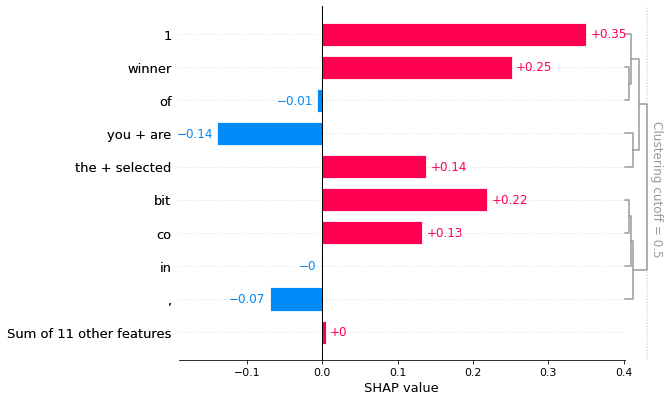

In [24]:
shap.plots.bar(shap_values[0,:,"LABEL_1"])